In [ ]:
# librerías
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import scipy as sp
import scipy.linalg as linalg
import sklearn as skl
import pandas as pd
import seaborn as sns
import time
import random
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from torchvision import datasets
from torchvision import transforms

In [ ]:
# para reproducibilidad
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

random.seed(0)
torch.manual_seed(0)
np.random.seed(0)

In [ ]:
# Para transformar a tensores
transform = transforms.Compose([transforms.ToTensor()])

# Descargar y cargar los datos
trainset = datasets.FashionMNIST('MNIST_data/', download = True, train = True, transform = transform)
testset = datasets.FashionMNIST('MNIST_data/', download = True, train = False, transform = transform)

100%|██████████| 26421880/26421880 [00:01<00:00, 13377830.21it/s]


Extracting MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to MNIST_data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 212813.85it/s]


Extracting MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to MNIST_data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3895125.29it/s]


Extracting MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to MNIST_data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 5136126.78it/s]

Extracting MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST_data/FashionMNIST/raw



In [ ]:
# Separamos el conjunto de entrenamiento en dos, uno que se usará para entrenar y otro para validar
trainset, validset = torch.utils.data.random_split(trainset, [50000, 10000])

In [ ]:
# Ver cómo queda la longitud de estos conjuntos
len(trainset),len(validset), len(testset)

(50000, 10000, 10000)

In [ ]:
# Etiquetas
labels_names = {
    0: "T-Shirt",    # Remera manga corta
    1: "Trouser",    # Pantalon
    2: "Pullover",   # Buzo
    3: "Dress",      # Vestido
    4: "Coat",       # Abrigo
    5: "Sandal",     # Sandalia
    6: "Shirt",      # Remera manga larga
    7: "Sneaker",    # Zapatilla
    8: "Bag",        # Bolso
    9: "Ankle Boot", # Bota
}

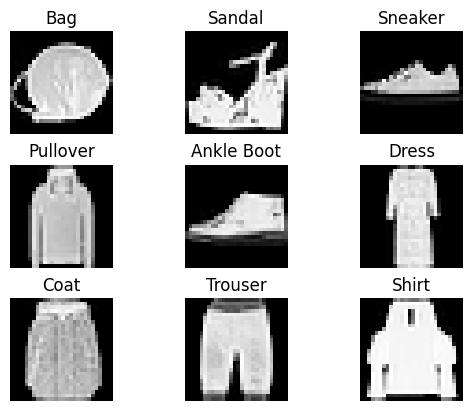

In [ ]:
# Ploteo de algunos ejemplos
figure = plt.figure()
cols,rows = 3,3
classes = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot']

for i in range(1,cols*rows+1):
  j = torch.randint(len(trainset),size=(1,)).item() # Los números aleatorios tambien se pueden generar desde pytorch. Util para trabajar en la GPU.
  image,label = trainset[j]
  while labels_names[label] not in classes:
    j = torch.randint(len(trainset),size=(1,)).item()
    image,label = trainset[j]
  classes.remove(labels_names[label])
  figure.add_subplot(rows,cols,i)
  plt.subplots_adjust(hspace=0.3)
  plt.title(labels_names[label])
  plt.axis("off")
  plt.imshow(image.squeeze(),cmap="Greys_r")
plt.savefig("Ejemplos")
plt.show()

In [ ]:
# Hay que pasar por estas clases por cómo vino el dataset (con un output con la label)
class CustomDataset(Dataset):
    def __init__(self,dataset):
        self.dataset=dataset
    # Redefinimos el método .__len__()
    def __len__(self):
        return len(self.dataset)
    # Redefinimos el método .__getitem__()
    def __getitem__(self,i):
        image,label=self.dataset[i]
        input  = image
        output = torch.flatten(image) # Reescribimos el label original con una version achatada de la imagen.
        return input,output

# Aplicamos a los conjuntos que tenemos
trainset = CustomDataset(trainset)
validset = CustomDataset(validset)
testset = CustomDataset(testset)

In [ ]:
# Hacemos los minibatchs
batch_size = 1000
trainloader = torch.utils.data.DataLoader(trainset, batch_size = batch_size, shuffle = True)  #solo es necesario shuffle=True para modificar pesos
validloader = torch.utils.data.DataLoader(validset, batch_size = batch_size, shuffle = False)
testloader = torch.utils.data.DataLoader(testset, batch_size = batch_size, shuffle = False)

RED:

In [ ]:
# Definimos la arquitectura de la red neuoronal
class NeuralNetwork(nn.Module):
    def __init__(self, n, p=0.1, name='modelo'):
        super(NeuralNetwork, self).__init__()
        self.n = n
        self.name = name

        #listas del error como atributoos, se inicializan como vacías
        self.list_train_avg_loss_entrenamiento = []
        self.list_train_avg_loss_entrenada = []
        self.list_valid_avg_loss = []

        self.flatten = nn.Flatten() # "capa" flatten
        self.capa1 = nn.Linear(28*28,n) # capa1 = "capa" fully connected 1
        self.relu = nn.ReLU() # "capa" relu
        self.dropo = nn.Dropout(p) # "capa" dropout
        self.capa2 = nn.Linear(n,28*28) # capa2 = "capa" fully connected 2
    def forward(self, x):
        x = self.flatten(x)
        x = self.capa1(x)
        x = self.relu(x)
        x = self.dropo(x)
        x = self.capa2(x)
        return x

In [ ]:
# Definimos la función de entrenamiento
def train_loop(dataloader,model,loss_fn,optimizer):
    # Activamos la maquinaria de entrenamiento del modelo
    model.train()
    # Definimos ciertas constantes
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    sum_loss,sum_correct = 0,0
    # Iteramos sobre lotes (batchs)
    for batch, (X, y) in enumerate(dataloader):
        # Copiamos las entradas y las salidas al dispositivo de trabajo
        X = X.to(device)
        y = y.to(device)
        # Calculamos la predicción del modelo y la correspondiente pérdida (error)
        pred = model(X)
        loss = loss_fn(pred,y)
        # Backpropagamos usando el optimizador proveido.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Imprimimos el progreso...
        loss_value = loss.item()
        sum_loss += loss_value

        if batch % 10 == 0:
            current = batch*len(X)
            print(f"batch={batch} loss={loss_value:>7f}  muestras-procesadas:[{current:>5d}/{size:>5d}]")
    avg_loss = sum_loss/num_batches

    return avg_loss

# De manera similar, definimos la función de prueba
def test_loop(dataloader,model,loss_fn):
    # Desactivamos la maquinaria de entrenamiento del modelo
    model.eval()
    # Definimos ciertas constantes
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    sum_loss,sum_correct = 0,0
    # Para testear, desactivamos el cálculo de gradientes.
    with torch.no_grad():
        # Iteramos sobre lotes (batches)
        for X,y in dataloader:
            # Copiamos las entradas y las salidas al dispositivo de trabajo
            X = X.to(device)
            y = y.to(device)
            # Calculamos las predicciones del modelo...
            pred = model(X)
            # y las correspondientes pérdidas (errores), los cuales vamos acumulando en un valor total.
            sum_loss += loss_fn(pred,y).item()

    avg_loss = sum_loss/num_batches

    print(f"Test Error: \n  Avg loss: {avg_loss:>8f}")
    return avg_loss

def valid_loop(dataloader, model, loss_fn, conj_entrenamiento=False):
    # Desactivamos la maquinaria de entrenamiento del modelo
    model.eval()
    # Definimos ciertas constantes
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    sum_loss,sum_correct = 0,0
    # Para testear, desactivamos el cálculo de gradientes.
    with torch.no_grad():
        # Iteramos sobre lotes (batches)
        for X,y in dataloader:
            # Copiamos las entradas y las salidas al dispositivo de trabajo
            X = X.to(device)
            y = y.to(device)
            # Calculamos las predicciones del modelo...
            pred = model(X)
            # y las correspondientes pérdidas (errores), los cuales vamos acumulando en un valor total.
            sum_loss += loss_fn(pred,y).item()

    # Calculamos la pérdida total y la fracción de clasificaciones correctas, y las imprimimos.
    avg_loss = sum_loss/num_batches
    if conj_entrenamiento==False:
      print(f"Valid Error: \n  Avg loss: {avg_loss:>8f} \n")
    else:
      print(f"Entrenamiento Error: \n  Avg loss: {avg_loss:>8f} \n")
    return avg_loss

En PyTorch, puedes verificar si el Dropout está activado o desactivado utilizando el método model.training. Este método devuelve True si el modelo está en modo de entrenamiento y False si está en modo de evaluación (prueba/inferencia). Durante el entrenamiento, PyTorch activa automáticamente el Dropout, y durante la evaluación, el Dropout se desactiva.

In [ ]:
# Función de pérdida
loss_fn = nn.MSELoss()

In [ ]:
# Red neuronal con 64 neuronas en la capa oculta
n = 64
model = NeuralNetwork(n)

In [ ]:
# Optimizador como Stochastic Gradient Descent
learning_rate = 0.5 # necesario para definir
optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)
#optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate,eps=1e-08,weight_decay=0,amsgrad=False)

In [ ]:
# Determinamos en que dispositivo vamos a trabajar, una CPU o una GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Pasamos el modelo al dispositivo
model = model.to(device)

In [ ]:
# Finalmente, entrenamos iterando sobre épocas.
# Además, hacemos la validación del modelo en cada una de ellas.
def entrenamiento(model):
   # Medir el tiempo de ejecución, inicio el tiempo
  inicio = time.time()
  num_epochs = 30

  for epoch in range(num_epochs):
      print(f"Epoch {epoch+1}\n-------------------------------")
      train_avg_loss_entrenamiento = train_loop(trainloader,model,loss_fn,optimizer)
      train_avg_loss_entrenada = valid_loop(trainloader, model, loss_fn, conj_entrenamiento=True)
      valid_avg_loos = valid_loop(validloader,model,loss_fn)

      # guardo cada errores en las listas creadas como atributos del modelo
      model.list_train_avg_loss_entrenamiento.append(train_avg_loss_entrenamiento)
      model.list_valid_avg_loss.append(valid_avg_loos)
      model.list_train_avg_loss_entrenada.append(train_avg_loss_entrenada)
  # Finalizo el tiempo de ejecución
  fin = time.time()
  # Calcular el tiempo transcurrido
  tiempo_transcurrido = fin - inicio
  print("Done!")
  print(f"El modelo tardó {tiempo_transcurrido} segundos en ejecutarse.")

In [ ]:
entrenamiento(model)

Epoch 1
-------------------------------
batch=0 loss=0.223489  muestras-procesadas:[    0/50000]
batch=10 loss=0.204302  muestras-procesadas:[10000/50000]
batch=20 loss=0.192890  muestras-procesadas:[20000/50000]
batch=30 loss=0.174691  muestras-procesadas:[30000/50000]
batch=40 loss=0.163957  muestras-procesadas:[40000/50000]
Entrenamiento Error: 
  Avg loss: 0.142486 

Valid Error: 
  Avg loss: 0.140937 

Epoch 2
-------------------------------
batch=0 loss=0.147530  muestras-procesadas:[    0/50000]
batch=10 loss=0.129676  muestras-procesadas:[10000/50000]
batch=20 loss=0.115627  muestras-procesadas:[20000/50000]
batch=30 loss=0.104727  muestras-procesadas:[30000/50000]
batch=40 loss=0.093890  muestras-procesadas:[40000/50000]
Entrenamiento Error: 
  Avg loss: 0.077355 

Valid Error: 
  Avg loss: 0.076861 

Epoch 3
-------------------------------
batch=0 loss=0.086168  muestras-procesadas:[    0/50000]
batch=10 loss=0.084753  muestras-procesadas:[10000/50000]
batch=20 loss=0.078421 

In [ ]:
# Gráfico para ver plots la loss cómo baja
def grafico(list_models):
  plt.xlabel('epoch')
  plt.ylabel('loss')
  paleta_colores_entrenada = sns.color_palette("bright")
  paleta_colores_valid = sns.color_palette("husl", 8)
  for i in range(len(list_models)):
    plt.plot(range(1,len(list_models[i].list_train_avg_loss_entrenada)+1), list_models[i].list_train_avg_loss_entrenada,
            label=f"train error n={list_models[i].n}", linestyle='-', c=paleta_colores_entrenada[i], linewidth=2.5)

    plt.plot(range(1,len(list_models[i].list_valid_avg_loss)+1), list_models[i].list_valid_avg_loss,
            label=f"valid error n={list_models[i].n}", linestyle='--', c=paleta_colores_valid[i], linewidth=2.5)
  plt.legend()
  plt.savefig('errores')
  plt.show()


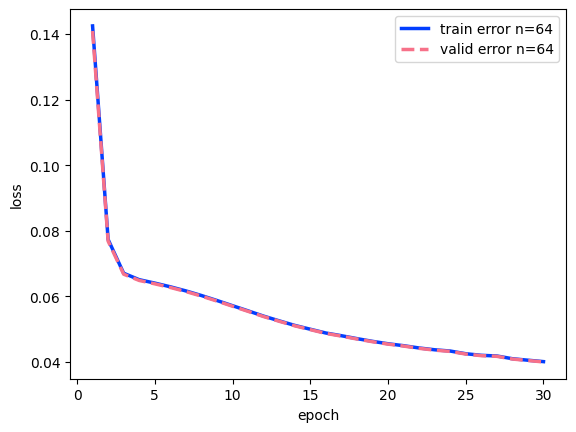

In [ ]:
grafico([model])

In [ ]:
test_loop(testloader,model,loss_fn)

Test Error: 
  Avg loss: 0.039926


0.03992554247379303

In [ ]:
# gráfica de algunos ejemplos comparando la original con la predicción
def ejemplos(model):
  model.eval()
  rows = 3 # Cantidad de ejemplos
  figure = plt.figure(figsize=(4,4))
  plt.suptitle(f'n={model.n}')
  for i in range(0,rows):
      j = torch.randint(len(testset),size=(1,)).item() # obtengo una fila al azar del conjunto
      image = testset[j][0].to(device) # obtengo la imagen
      predict = (torch.reshape(model(image), (28, 28))).to('cpu').detach().numpy() # predicción de la imágen

      # imagen original
      figure.add_subplot(rows,2,2*i+1)
      if i==0:
        plt.title('Original')
      plt.axis("off")
      plt.imshow(image.squeeze().to('cpu'), cmap="Greys_r")

      # predicción
      figure.add_subplot(rows,2,2*(i+1))
      if i==0:
        plt.title('Autoencoder')
      plt.axis("off")
      plt.imshow(predict, cmap="Greys_r")

  # la guarda en el directorio
  plt.savefig(f'Ejemplo n={model.n}', bbox_inches='tight', pad_inches=0.1)
  plt.show()

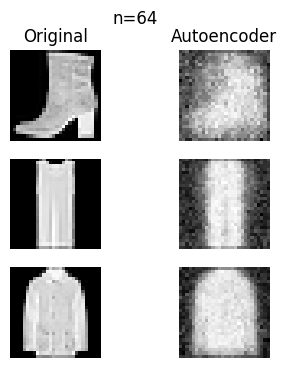

In [ ]:
ejemplos(model)

In [ ]:
!pip install torchview

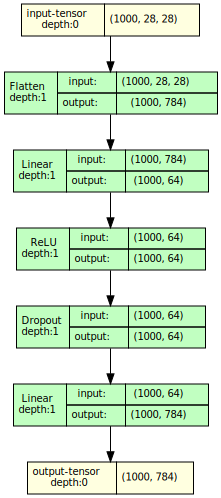

In [ ]:
from torchview import draw_graph
import graphviz

# Define the device (CPU or GPU)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Move the model to the device
model.to(device)

# Visualize the computational graph without performing a forward pass
model_graph = draw_graph(model=model, input_size=(batch_size, 28, 28), expand_nested=True, device=device)
model_graph.visual_graph.render('graph', format='svg', view=True)
model_graph.visual_graph

## Modelo con 128 neuronas capa oculta

In [ ]:
n = 128
model_2 = NeuralNetwork(n, name='Modelo_2')
model_2.to(device)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (capa1): Linear(in_features=784, out_features=128, bias=True)
  (relu): ReLU()
  (dropo): Dropout(p=0.1, inplace=False)
  (capa2): Linear(in_features=128, out_features=784, bias=True)
)

In [ ]:
optimizer = torch.optim.SGD(model_2.parameters(),lr=learning_rate)

In [ ]:
entrenamiento(model_2)

Epoch 1
-------------------------------
batch=0 loss=0.228167  muestras-procesadas:[    0/50000]
batch=10 loss=0.194427  muestras-procesadas:[10000/50000]
batch=20 loss=0.174499  muestras-procesadas:[20000/50000]
batch=30 loss=0.138748  muestras-procesadas:[30000/50000]
batch=40 loss=0.104976  muestras-procesadas:[40000/50000]
Entrenamiento Error: 
  Avg loss: 0.078907 

Valid Error: 
  Avg loss: 0.078406 

Epoch 2
-------------------------------
batch=0 loss=0.089342  muestras-procesadas:[    0/50000]
batch=10 loss=0.079243  muestras-procesadas:[10000/50000]
batch=20 loss=0.076670  muestras-procesadas:[20000/50000]
batch=30 loss=0.073442  muestras-procesadas:[30000/50000]
batch=40 loss=0.071394  muestras-procesadas:[40000/50000]
Entrenamiento Error: 
  Avg loss: 0.063218 

Valid Error: 
  Avg loss: 0.062981 

Epoch 3
-------------------------------
batch=0 loss=0.073285  muestras-procesadas:[    0/50000]
batch=10 loss=0.070421  muestras-procesadas:[10000/50000]
batch=20 loss=0.070701 

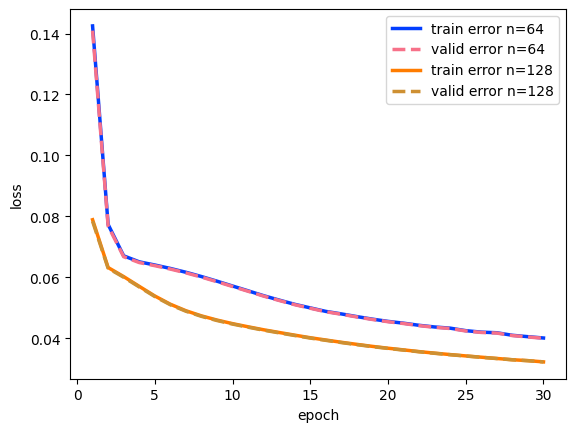

In [ ]:
grafico([model, model_2])

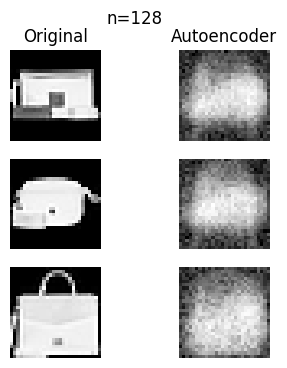

In [ ]:
ejemplos(model_2)

In [ ]:
test_loop(testloader,model_2,loss_fn)

Test Error: 
  Avg loss: 0.032165


0.03216520715504885

## Modelo con 256 neuronas capa oculta

In [ ]:
n = 256
model_3 = NeuralNetwork(n, name='Modelo_3')
model_3.to(device)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (capa1): Linear(in_features=784, out_features=256, bias=True)
  (relu): ReLU()
  (dropo): Dropout(p=0.1, inplace=False)
  (capa2): Linear(in_features=256, out_features=784, bias=True)
)

In [ ]:
optimizer = torch.optim.SGD(model_3.parameters(),lr=learning_rate)

In [ ]:
entrenamiento(model_3)

Epoch 1
-------------------------------
batch=0 loss=0.213796  muestras-procesadas:[    0/50000]
batch=10 loss=0.169936  muestras-procesadas:[10000/50000]
batch=20 loss=0.124908  muestras-procesadas:[20000/50000]
batch=30 loss=0.087191  muestras-procesadas:[30000/50000]
batch=40 loss=0.076893  muestras-procesadas:[40000/50000]
Entrenamiento Error: 
  Avg loss: 0.064685 

Valid Error: 
  Avg loss: 0.064449 

Epoch 2
-------------------------------
batch=0 loss=0.072603  muestras-procesadas:[    0/50000]
batch=10 loss=0.070413  muestras-procesadas:[10000/50000]
batch=20 loss=0.068449  muestras-procesadas:[20000/50000]
batch=30 loss=0.065881  muestras-procesadas:[30000/50000]
batch=40 loss=0.066928  muestras-procesadas:[40000/50000]
Entrenamiento Error: 
  Avg loss: 0.059416 

Valid Error: 
  Avg loss: 0.059219 

Epoch 3
-------------------------------
batch=0 loss=0.065498  muestras-procesadas:[    0/50000]
batch=10 loss=0.064882  muestras-procesadas:[10000/50000]
batch=20 loss=0.064512 

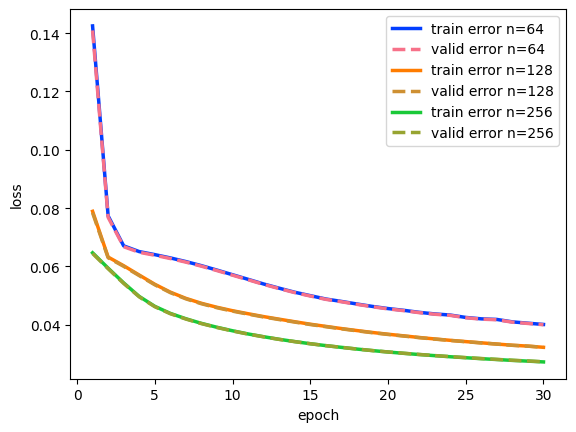

In [ ]:
grafico([model, model_2, model_3])

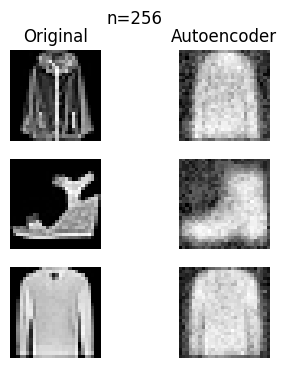

In [ ]:
ejemplos(model_3)

In [ ]:
test_loop(testloader,model_3,loss_fn)

Test Error: 
  Avg loss: 0.027209


0.027209203317761423

## Modelo con 512 neuronas capa oculta

In [ ]:
n = 512
model_4 = NeuralNetwork(n, name='Modelo_4')
model_4.to(device)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (capa1): Linear(in_features=784, out_features=512, bias=True)
  (relu): ReLU()
  (dropo): Dropout(p=0.1, inplace=False)
  (capa2): Linear(in_features=512, out_features=784, bias=True)
)

In [ ]:
optimizer = torch.optim.SGD(model_4.parameters(),lr=learning_rate)
#optimizer = torch.optim.Adam(model_4.parameters(),lr=learning_rate,eps=1e-08,weight_decay=0,amsgrad=False)

In [ ]:
entrenamiento(model_4)

Epoch 1
-------------------------------
batch=0 loss=0.223490  muestras-procesadas:[    0/50000]
batch=10 loss=0.138104  muestras-procesadas:[10000/50000]
batch=20 loss=0.081579  muestras-procesadas:[20000/50000]
batch=30 loss=0.070782  muestras-procesadas:[30000/50000]
batch=40 loss=0.064750  muestras-procesadas:[40000/50000]
Entrenamiento Error: 
  Avg loss: 0.060228 

Valid Error: 
  Avg loss: 0.060012 

Epoch 2
-------------------------------
batch=0 loss=0.065390  muestras-procesadas:[    0/50000]
batch=10 loss=0.063955  muestras-procesadas:[10000/50000]
batch=20 loss=0.062991  muestras-procesadas:[20000/50000]
batch=30 loss=0.060990  muestras-procesadas:[30000/50000]
batch=40 loss=0.057943  muestras-procesadas:[40000/50000]
Entrenamiento Error: 
  Avg loss: 0.052163 

Valid Error: 
  Avg loss: 0.051994 

Epoch 3
-------------------------------
batch=0 loss=0.055907  muestras-procesadas:[    0/50000]
batch=10 loss=0.055542  muestras-procesadas:[10000/50000]
batch=20 loss=0.054861 

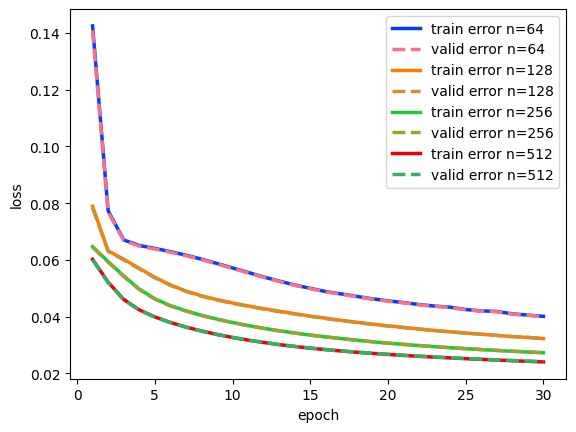

In [ ]:
grafico([model, model_2, model_3, model_4])

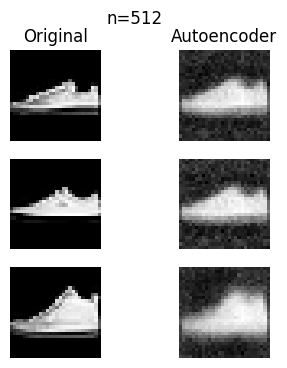

In [ ]:
ejemplos(model_4)

In [ ]:
test_loop(testloader,model_4,loss_fn)

Test Error: 
  Avg loss: 0.024026


0.024025915749371053